

# ArviZ Stancon 2020

Käyttäessäsi interaktiivisia kalvoja binder avulla, etene seuraavalle kalvolle painamalla `välilyöntiä`.

# ArviZ and Inference Data


## Sisältö
* Bayesilaisen työnkulun monet vaiheet.
* Mihin ArviZ soveltuu
* Mihin InferenceData soveltuu
* Mikä on yhteisön rooli
* Mitä on vielä työnalla (toistaiseksi)
* Mihin on sinun roolisi

# Bayesilainen työnkulku
Työnkulku sisältää monta vaihetta. Tilastolliset ohjelmointikielet auttavat vain joissain vaiheissa. ArviZ:n tavoitteena on auttaa työnkulun lopuissa vaiheissa.

![Bayesian Workflow](img/Bayesian_workflow_Updated.png)

# Kaikki MCMC ketjut johtavat kuvaajaan
Tilastollisen ohjelmointikielen valintaan vaikuttaa moni asia syntaksista otanta-algoritmiin (sampler), mutta ketjut, otanta (draw/samples), diagnostiikka, visualisoinnit ja mallintamisen motiivit ovat suurelta samat

![PPLs](img/PPLS.png)

# Tensoreita kaikkialla
* Prioriprediktiivi
* Posteriori
* Poikkeamat (divergences)
* log-todennäköisyydet diagnostiikkaan
* Näiden lisäksi tensoreiden muodon muutokset mallista riippuen

Datakehykset (dataframe) toimivalla indeksoinnilla on osoittautunut hyödylliseksi data-analyysille.
Bayesilainen data on luonnostaan monidimensionaalista, mutta data-analyysin kannalta on läheinen datakehysten käytön kanssa.


# Inference Data yhtenä ratkaisuna
* Täydelliset tiedot (en) https://arviz-devs.github.io/arviz/schema/schema.html
* Kukin NetCDF ryhmä varastoi erillisen informaation

![idata](https://arviz-devs.github.io/arviz/_images/InferenceDataStructure.png)


# InferenceData pikaisesti
* Lue paikallisia netCDF tiedostoja
* Luo `InferenceData` PyStan sovituksesta (fit) 

Lisäksi käyttöliittymä Pythonilla löytyy [CmdStanPy](https://arviz-devs.github.io/arviz/notebooks/InferenceDataCookbook.html#From-CmdStanPy), [CmdStan](https://arviz-devs.github.io/arviz/notebooks/InferenceDataCookbook.html#From-CmdStan) ja Julialla [CmdStan.jl](https://arviz-devs.github.io/ArviZ.jl/stable/quickstart.html#Plotting-with-CmdStan.jl-outputs-1)

## Lue paikallisia netCDF tiedostoja

In [1]:
import arviz as az

# Ladataan ennalta laskettu .nc tiedosto internetistä.
# az.from_netcdf("radon.nc") paikalliselle tiedostolle
idata = az.load_arviz_data("radon")
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> observed_data

In [2]:
az.style.use("arviz-darkgrid")
az.rcParams["stats.ic_pointwise"] = True

## Luo InferenceData PyStan sovituksesta (fit)

In [3]:
# Inference Data yhteensopiva eri Stan käyttöliittymien kanssa (Kiitos Ari, Allen ja Mitzi!)
import pystan
from scipy import stats
y = stats.norm(10, 1).rvs(1000)
model = """
data {int N; real y[N];} parameters {real mu; real<lower=0> sigma;}
model { mu ~ normal(0, 1); sigma ~ cauchy(0, 1); y ~ normal(mu, sigma);}
"""
stan_model = pystan.StanModel(model_code=model, extra_compile_args=['-flto'])
fit = stan_model.sampling(data={"y":y, 'N':len(y)})

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7068b6fd3880b0f3a68d15c5c43d21aa NOW.


In [4]:
idata_pystan = az.from_pystan(
    posterior=fit,
    observed_data=["y"],
)
idata_pystan

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

# Jäsennelty data helpottaa monimutkaisia laskentoja

## Posteriorin tutkiminen and diagnoosit

<table style="color:#bbb">
  <tr>
    <th><span style="color:#000">posterior</span></th>
    <th><span style="color:#000">sample stats</span></th>
    <th>log likelihood</th>
    <th>posterior predictive</th>
    <th>observed data</th>
    <th>prior</th>
    <th>prior predictive</th>
  </tr>
</table>

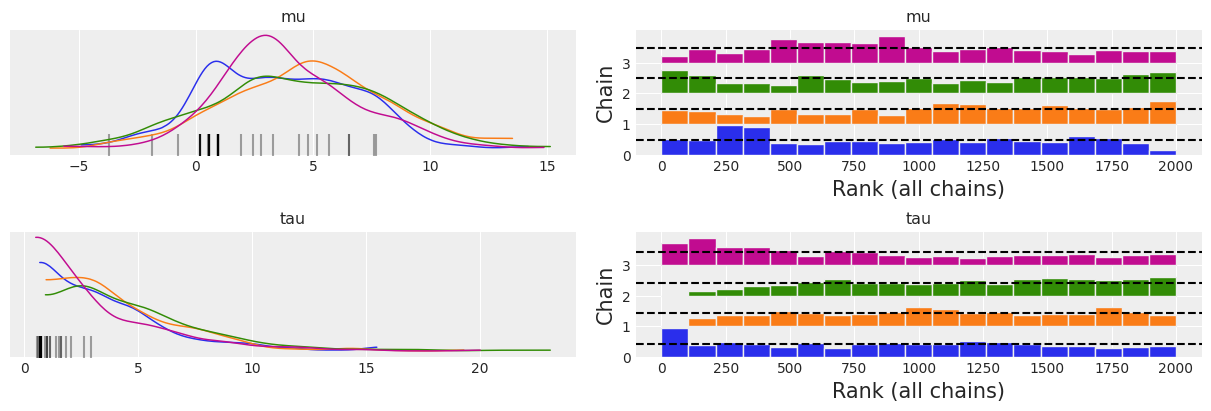

In [5]:
az.plot_trace(az.load_arviz_data("centered_eight"), var_names=["mu", "tau"], kind="rank_bars");

## Yksi-pois -ristiinvalidointi (PSIS-LOO)

<table style="color:#bbb">
  <tr>
    <th>posterior</th>
    <th>sample stats</th>
    <th><span style="color:#000">log likelihood</span></th>
    <th>posterior predictive</th>
    <th>observed data</th>
    <th>prior</th>
    <th>prior predictive</th>
  </tr>
</table>

In [5]:
az.loo(idata)

Computed from 2000 by 919 log-likelihood matrix

         Estimate       SE
elpd_loo -1026.64    29.29
p_loo       23.27        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      917   99.8%
 (0.5, 0.7]   (ok)          2    0.2%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

## Prioriprediktiiviset tarkastukset

<table style="color:#bbb">
  <tr>
    <th>posterior</th>
    <th>sample stats</th>
    <th>log likelihood</th>
    <th>posterior predictive</th>
    <th><span style="color:#000">observed data</span></th>
    <th>prior</th>
    <th><span style="color:#000">prior predictive</span></th>
  </tr>
</table>

In [6]:
az.plot_ppc(idata, group="prior");

TypeError: `data` argument must have the group "prior_predictive" for ppcplot

## Yksi-pois -ristiinvalidointi todennäköisyys integraali (LOO-PIT)

<table style="color:#bbb">
  <tr>
    <th>posterior</th>
    <th>sample stats</th>
    <th><span style="color:#000">log likelihood</span></th>
    <th><span style="color:#000">posterior predictive</span></th>
    <th><span style="color:#000">observed data</span></th>
    <th>prior</th>
    <th>prior predictive</th>
  </tr>
</table>

In [8]:
az.plot_loo_pit(idata, y="y");

KeyError: 'y'

# ArviZ ja InferenceData hyödyt
* Johdonmukainen data esitys tilastollisesta ohjelmointikielestä riippumatta
* Tallennettava ja paljon käytetty netCDF format
* Jaettavat tulokset rohkaisevat toistettavuuteen
* Mahdollista tilastollisten ohjelmointikielien kehittäjien keskittyä itse kieleen, jolloin ei tarvitse tuottaa otannan jälkeisen diagnostiikan ja kuvaajien luomista

# Inference Data rajoitukset
* InferenceData on suunniteltu MCMC otannalle
* Ei tee bayesialaisesta työnkulusta vielä täysin toistettavaa, ainoastaan osasta siitä

# Lisää tuki InferenceDatalle ohjelmaasi
* InferenceDataa voi käyttää vain formaatin määrittelyyn. 
* ArviZ tai Python käyttö ei ole pakollista

![](img/ArviZ.R.png)

# Ydinpaketti voisi hyödyntää apuasi!
* `InferenceData`:n kehittäminen, katso [malli](https://arviz-devs.github.io/arviz/schema/schema.html)
* Visualisointien ja diagnostiikan lisäys
* Koodaa, anna palautetta, julkaise ja jaa mallisi ja luomasi kuvaajat
* Parannuksia kuten tuki harvalle datalle (sparse data structures)

## Lisäinfo (en)

* https://arviz-devs.github.io/arviz/
* https://arviz-devs.github.io/ArviZ.jl/stable/
* https://arviz-devs.github.io/arviz/notebooks/XarrayforArviZ.html
* https://arviz-devs.github.io/arviz/schema/schema.html